# Exercise 8 | Anomaly Detection
---

In [1]:
%  Instructions
%  ------------
%
%  This file contains code that helps you get started on the
%  exercise. You will need to complete the following functions:
%
%     estimateGaussian.m
%     selectThreshold.m
%     cofiCostFunc.m
%
%  For this exercise, you will not need to change any code in this file,
%  or any other files other than those mentioned above.

In [14]:
%% Initialization
clear ; close all; clc

In [15]:
%% ================== Part 1: Load Example Dataset  ===================
%  We start this exercise by using a small dataset that is easy to
%  visualize.
%
%  Our example case consists of 2 network se# rver statistics across
%  several machines: the latency and throughput of each machine.
%  This exercise will help us find possibly faulty (or very fast) machines.

In [16]:
fprintf('Visualizing example dataset for outlier detection.\n\n');

Visualizing example dataset for outlier detection.



In [17]:
%  The following command loads the dataset. You should now have the
%  variables X, Xval, yval in your environment
load('ex8data1.mat');

In [6]:
whos

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        X         307x2                       4912  double
        Xval      307x2                       4912  double
        yval      307x1                       2456  double

Total is 1535 elements using 12280 bytes



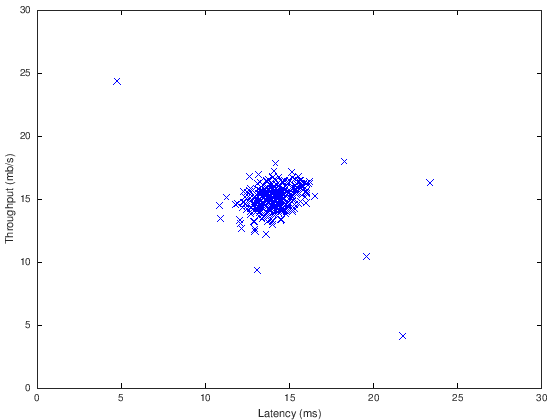

In [7]:
%  Visualize the example dataset
plot(X(:, 1), X(:, 2), 'bx');
axis([0 30 0 30]);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

In [8]:
%% ================== Part 2: Estimate the dataset statistics ===================
%  For this exercise, we assume a Gaussian distribution for the dataset.
%
%  We first estimate the parameters of our assumed Gaussian distribution, 
%  then compute the probabilities for each of the points and then visualize 
%  both the overall distribution and where each of the points falls in 
%  terms of that distribution.

In [9]:
fprintf('Visualizing Gaussian fit.\n\n');

Visualizing Gaussian fit.



### Anomaly detection algorithm
#### 1. Multivariate Gaussian (Normal) distribution
1. Choose features $x_j$ that you think might be indicative of anomalous examples.
2. Fit parameters $\mu_1,...,\mu_n,\sigma_1^2,...,\sigma_n^2$  
$\mu_j = \frac{1}{m}\sum\limits_{i=1}^{m}x_j^{(i)}$  
$\sigma_j^2=\frac{1}{m}\sum\limits_{i=1}^{m}\big(x_j^{(i)} - \mu_j\big)^2$  
3. Given new example $x$, compute $p(x)$:  
$p(x)=\prod\limits_{j=1}^{n}p\big(x_j;\mu_j,\sigma_j^2\big) = \prod\limits_{j=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_j} exp\big(-\frac{(x_j-\mu_j)^2}{2\sigma_j^2}\big)$  
Anomaly if $p(x) < \varepsilon$  

#### 2. Multivariate Gaussian (Normal) distribution
Parameters $\mu, \Sigma$  
$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} exp \Big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\Big)$  
Parameter fitting: Given training set $\big\{x^{(1)},x^{(2)},...,x^{(m)}\big\}$  
$\mu = \frac{1}{m}\sum\limits_{i=1}^{m}x^{(i)}$  
$\Sigma=\frac{1}{m}\sum\limits_{i=1}^{m}\big(x^{(i)}-\mu\big)\big(x^{(i)}-\mu\big)^T$



In [10]:
%数据初始化
X =[13 105;19 87;50 90;16 93;18 100;21 85;11 90]   %shape=(7*2)
X = X - mean(X)    %数据减去本列均值
X'
%协方差
C = (X'*X)/(length(X)-1)
%标准差
S = sum(X.^2)/(length(X)-1)
%所以正对角线上的数据与方差一致，而反对角线上数据标准不同列之间的相关性。 
%正数：正相关 
%负数：负相关 
%零：不相关
% https://blog.csdn.net/weixin_40920228/article/details/80574332

X =

    13   105
    19    87
    50    90
    16    93
    18   100
    21    85
    11    90

X =

   -8.14286   12.14286
   -2.14286   -5.85714
   28.85714   -2.85714
   -5.14286    0.14286
   -3.14286    7.14286
   -0.14286   -7.85714
  -10.14286   -2.85714

ans =

   -8.14286   -2.14286   28.85714   -5.14286   -3.14286   -0.14286  -10.14286
   12.14286   -5.85714   -2.85714    0.14286    7.14286   -7.85714   -2.85714

C =

   173.810   -26.976
   -26.976    51.810

S =

   173.810    51.810



In [18]:
function [mu sigma2] = estimateGaussian(X)
%ESTIMATEGAUSSIAN This function estimates the parameters of a 
%Gaussian distribution using the data in X
%   [mu sigma2] = estimateGaussian(X), 
%   The input X is the dataset with each n-dimensional data point in one row
%   The output is an n-dimensional vector mu, the mean of the data set
%   and the variances sigma^2, an n x 1 vector
%
% Useful variables
[m, n] = size(X);
% You should return these values correctly
mu = zeros(n, 1);
sigma2 = zeros(n, 1);
% ====================== YOUR CODE HERE ======================
% Instructions: Compute the mean of the data and the variances
%               In particular, mu(i) should contain the mean of
%               the data for the i-th feature and sigma2(i)
%               should contain variance of the i-th feature.
%
mu=sum(X)/m;
sigma2=sum((X - mu) .^ 2)/m;

% =============================================================
end

In [19]:
%  Estimate my and sigma2
[mu sigma2] = estimateGaussian(X);

In [20]:
mu
sigma2

mu =

   14.112   14.998

sigma2 =

   1.8326   1.7097



In [23]:
function p = multivariateGaussian(X, mu, Sigma2)
%MULTIVARIATEGAUSSIAN Computes the probability density function of the
%multivariate gaussian distribution.
%    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
%    density function of the examples X under the multivariate gaussian 
%    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
%    treated as the covariance matrix. If Sigma2 is a vector, it is treated
%    as the \sigma^2 values of the variances in each dimension (a diagonal
%    covariance matrix)
%
k = length(mu);
if (size(Sigma2, 2) == 1) || (size(Sigma2, 1) == 1)
    Sigma2 = diag(Sigma2);
end
X = bsxfun(@minus, X, mu(:)');
p = (2 * pi) ^ (- k / 2) * det(Sigma2) ^ (-0.5) * ...
    exp(-0.5 * sum(bsxfun(@times, X * pinv(Sigma2), X), 2));
end

In [128]:
%  Returns the density of the multivariate normal at each data point (row) 
%  of X
p = multivariateGaussian(X, mu, sigma2); size(p), p

ans =

   307     1

p =

   6.4708e-02
   5.0304e-02
   7.2450e-02
   5.0316e-02
   6.3685e-02
   4.2458e-02
   4.7909e-02
   3.6511e-02
   1.8666e-02
   5.0688e-02
   2.6515e-02
   8.4713e-02
   7.1047e-02
   6.9553e-02
   3.7779e-02
   8.2703e-02
   8.7792e-02
   8.6876e-02
   6.9171e-02
   9.7347e-03
   7.5707e-02
   8.8377e-02
   3.7410e-02
   8.7138e-02
   4.1263e-02
   2.4880e-02
   7.9090e-02
   7.5923e-02
   8.0826e-02
   7.6640e-02
   5.0117e-02
   8.8050e-02
   6.1788e-02
   5.9623e-02
   2.0902e-02
   4.5794e-02
   3.5342e-02
   8.2129e-02
   7.2433e-02
   8.4979e-02
   6.4188e-02
   6.6478e-02
   8.3757e-02
   8.5762e-02
   6.9463e-02
   5.8848e-02
   3.3065e-02
   7.0309e-02
   7.7749e-02
   3.5989e-02
   7.3497e-02
   7.5621e-02
   8.5469e-02
   8.9786e-02
   7.5870e-02
   8.4445e-02
   8.6797e-02
   8.9350e-02
   7.8301e-02
   6.0997e-02
   6.8918e-02
   8.9399e-02
   2.3561e-02
   3.9218e-02
   3.4682e-02
   7.0582e-02
   3.3898e-02
   8.0907e-02
   2.3933e-02
   9.175

In [53]:
function visualizeFit(X, mu, sigma2)
%VISUALIZEFIT Visualize the dataset and its estimated distribution.
%   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
%   probability density function of the Gaussian distribution. Each example
%   has a location (x1, x2) that depends on its feature values.
%

[X1,X2] = meshgrid(0:.5:35); 
Z = multivariateGaussian([X1(:) X2(:)],mu,sigma2);
Z = reshape(Z,size(X1));

plot(X(:, 1), X(:, 2),'bx');
hold on;
% Do not plot if there are infinities
if (sum(isinf(Z)) == 0)
    contour(X1, X2, Z, 10.^(-20:3:0)');
end
hold off;

end

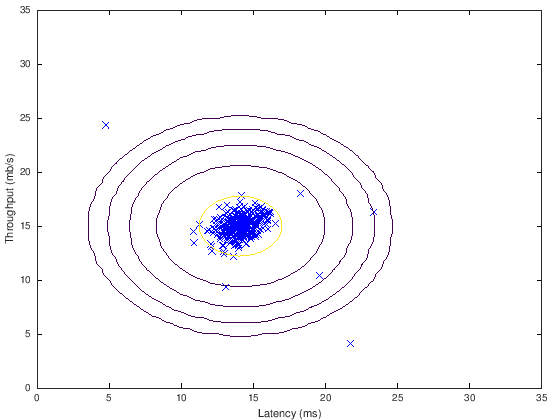

In [54]:
%  Visualize the fit
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

In [55]:
%% ================== Part 3: Find Outliers ===================
%  Now you will find a good epsilon threshold using a cross-validation set
%  probabilities given the estimated Gaussian distribution

In [124]:
function [bestEpsilon bestF1] = selectThreshold(yval, pval)
%SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
%outliers
%   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
%   threshold to use for selecting outliers based on the results from a
%   validation set (pval) and the ground truth (yval).
%

bestEpsilon = 0;
bestF1 = 0;
F1 = 0;

stepsize = (max(pval) - min(pval)) / 1000;
for epsilon = min(pval):stepsize:max(pval)
    
    % ====================== YOUR CODE HERE ======================
    % Instructions: Compute the F1 score of choosing epsilon as the
    %               threshold and place the value in F1. The code at the
    %               end of the loop will compare the F1 score for this
    %               choice of epsilon and set it to be the best epsilon if
    %               it is better than the current choice of epsilon.
    %               
    % Note: You can use predictions = (pval < epsilon) to get a binary vector
    %       of 0's and 1's of the outlier predictions

%predictions=(pval<epsilon);
%tp=sum((predictions==1)&(yval==1));
%fp=sum((predictions==1)&(yval==0));
%fn=sum((predictions==0)&(yval==1));

tp=sum(floor(((pval<epsilon)+yval)/2));
fp=sum(ceil(((pval<epsilon)-yval)/2));
fn=-sum(floor(((pval<epsilon)-yval)/2));

prec=tp/(tp+fp);
rec=tp/(tp+fn);
F1=2*prec*rec/(prec+rec);

    % =============================================================

    if F1 > bestF1
       bestF1 = F1;
       bestEpsilon = epsilon;
    end
    %fprintf('%f %f %f %f\n',F1, bestF1, bestEpsilon, epsilon)
end

end

In [125]:
pval = multivariateGaussian(Xval, mu, sigma2);
[epsilon F1] = selectThreshold(yval, pval);


    selectThreshold at line 35 column 5


In [126]:
fprintf('Best epsilon found using cross-validation: %e\n', epsilon);
fprintf('Best F1 on Cross Validation Set:  %f\n', F1);
fprintf('   (you should see a value epsilon of about 8.99e-05)\n');
fprintf('   (you should see a Best F1 value of  0.875000)\n\n');

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)



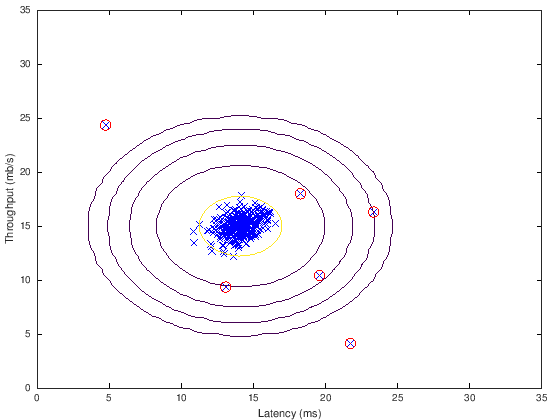

In [60]:
%  Find the outliers in the training set and plot the
outliers = find(p < epsilon);

%  Visualize the fit
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

%  Draw a red circle around those outliers
hold on
plot(X(outliers, 1), X(outliers, 2), 'ro', 'LineWidth', 2, 'MarkerSize', 10);
hold off

In [61]:
%% ================== Part 4: Multidimensional Outliers ===================
%  We will now use the code from the previous part and apply it to a 
%  harder problem in which more features describe each datapoint and only 
%  some features indicate whether a point is an outlier.

In [62]:
%  Loads the second dataset. You should now have the
%  variables X, Xval, yval in your environment
load('ex8data2.mat');

In [63]:
%  Apply the same steps to the larger dataset
[mu sigma2] = estimateGaussian(X);

In [64]:
%  Training set 
p = multivariateGaussian(X, mu, sigma2);

In [65]:
%  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2);

In [66]:
%  Find the best threshold
[epsilon F1] = selectThreshold(yval, pval);

    selectThreshold at line 35 column 5


In [67]:
fprintf('Best epsilon found using cross-validation: %e\n', epsilon);
fprintf('Best F1 on Cross Validation Set:  %f\n', F1);
fprintf('   (you should see a value epsilon of about 1.38e-18)\n');
fprintf('   (you should see a Best F1 value of 0.615385)\n');
fprintf('# Outliers found: %d\n\n', sum(p < epsilon));

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117

